<a href="https://colab.research.google.com/github/StuartLiv/CPSC-440-Project/blob/main/models/half_size_256.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from tqdm import tqdm
import re
from keras.preprocessing.image import img_to_array # TODO don't use keras
from keras.utils import load_img
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import random

from google.colab import userdata

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda


# 1. Set up project in runtime
Copy the following cell and run it with your credentials to clone the repo, getting datasets as runtime files, and then delete your credentials.

In [2]:
!git config --global user.email {userdata.get('email')}
!git config --global user.name {userdata.get('name')}
!git clone https://{userdata.get('token')}@github.com/StuartLiv/CPSC-440-Project
%pwd

Cloning into 'CPSC-440-Project'...
remote: Enumerating objects: 166315, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 166315 (delta 27), reused 14 (delta 7), pack-reused 166262
Receiving objects: 100% (166315/166315), 772.36 MiB | 37.66 MiB/s, done.
Resolving deltas: 100% (36905/36905), done.
Updating files: 100% (249454/249454), done.


'/content'

# 2. Preprocess data

Datasets:
- `largeset_multisize_v2`
  - Stored in Github repo, made from combination of other datasets. Dataset construction code in repo too
  - 16706 Images, in randomized order
  - Res 128x128 (grayscale images also available in 64x64, 32x32, 16x16)


In [3]:
''' Returns an array containing all images in folder, sorted by filename. Useful for color/gray/downsize versions in different folders with same filename.
@param path - directory with images
@return
'''
def make_image_arr(path):

  def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)

  files = os.listdir(path)
  files = sorted_alphanumeric(files)

  arr = []
  for i in tqdm(files):
    img = load_img(path + '/'+i)
    arr.append(img_to_array(img) / 255)

  return np.array(arr)


Load datasets, partition sets, and make tensors in color-layer order for convolutions



In [10]:
training_proportion = 0.8
validation_proportion = 0.0

def load_and_partition(path):
  arr = make_image_arr(path)
  cutoff = int(len(arr)*training_proportion)
  return arr[:cutoff], arr[cutoff:]

def make_tensor(arr):
  #Axis transformation: Shape (n, h, w, 3) -> (n, 3, h, w)
  #Inversion is np.moveaxis(arr, [2,2], [1,1])
  return torch.from_numpy(np.moveaxis(arr, [3,1], [1,2]))

  #Extract single channel, since all 3 are the same in gray images
def make_gray_tensor(arr):
  return make_tensor(arr)[:, 0:1, :, :]

color_train, color_test = load_and_partition('/content/CPSC-440-Project/datasets/medset_multisize/color')
gray_train, gray_test = load_and_partition('/content/CPSC-440-Project/datasets/medset_multisize/gray128')

assert(len(color_train) == len(gray_train) and len(color_test) == len(gray_test))
n_train = len(color_train)
n_test = len(color_test)

color_train_tensors = make_tensor(color_train)
color_test_tensors = make_tensor(color_test)

gray_train_tensors = make_gray_tensor(gray_train)
gray_test_tensors = make_gray_tensor(gray_test)

100%|██████████| 12000/12000 [00:04<00:00, 2468.58it/s]


3882


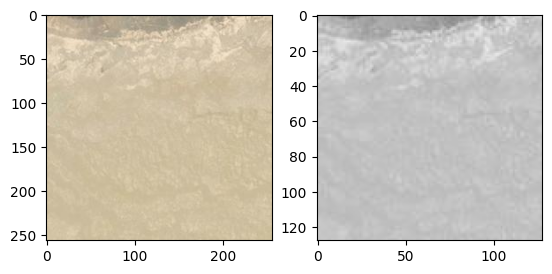

2772


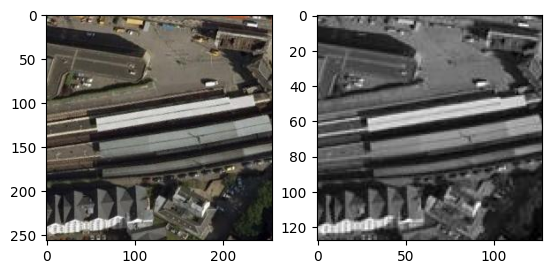

5296


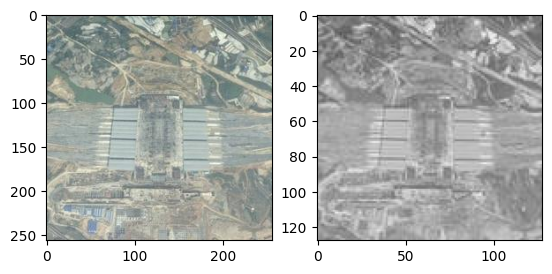

In [6]:
for i in np.random.randint(n_train,size=3):
  print(i)
  plt.subplot(1,2,1)
  plt.imshow(color_train[i])
  plt.subplot(1,2,2)
  plt.imshow(gray_train[i])
  plt.show()

# 3. Model
Model generated below:

In [11]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 256, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),

            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 3, 3, padding=1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Create the autoencoder
autoencoder = Autoencoder()

Load stored decoder from full size model training, and fix decoder parameters.

In [12]:
autoencoder.decoder = torch.load('/content/CPSC-440-Project/models/decoder_weights_256')
for param in autoencoder.decoder.parameters():
  param.requires_grad = False

(optionally) load pre-trained encoder

In [13]:
autoencoder.encoder = torch.load('/content/CPSC-440-Project/models/128_dim_encoder_weights')

Train Model (SGD)

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.encoder.parameters(), lr=0.001)
autoencoder.train()
autoencoder.to(device)

# Training loop
num_epochs = 5
num_iterations = 1000
batch_size=32
for epoch in range(num_epochs):
  for iteration in range(num_iterations):
      running_loss = 0.0
      batch_indexes = torch.randint(high=n_train, size=(batch_size,1))

      inputs = gray_train_tensors[batch_indexes].squeeze().to(device)
      targets = color_train_tensors[batch_indexes].squeeze().to(device)

      outputs = autoencoder(inputs)
      loss = criterion(outputs, targets)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
  print('[%d] loss: %.5f' % (epoch+1, running_loss / batch_size))

print('Finished Training')

[1] loss: 0.00020
[2] loss: 0.00019
[3] loss: 0.00021
[4] loss: 0.00020
[5] loss: 0.00015
[6] loss: 0.00016
[7] loss: 0.00017
[8] loss: 0.00016
[9] loss: 0.00014
[10] loss: 0.00012
[11] loss: 0.00016
[12] loss: 0.00017
[13] loss: 0.00013
[14] loss: 0.00015
[15] loss: 0.00013
[16] loss: 0.00016
[17] loss: 0.00014
[18] loss: 0.00013
[19] loss: 0.00014
[20] loss: 0.00017
[21] loss: 0.00015
[22] loss: 0.00012
[23] loss: 0.00017
[24] loss: 0.00015
[25] loss: 0.00016
[26] loss: 0.00017
[27] loss: 0.00013
[28] loss: 0.00012
[29] loss: 0.00016
[30] loss: 0.00012
[31] loss: 0.00018
[32] loss: 0.00015
[33] loss: 0.00014
[34] loss: 0.00016
[35] loss: 0.00015
[36] loss: 0.00018
[37] loss: 0.00014
[38] loss: 0.00014
[39] loss: 0.00018
[40] loss: 0.00013
[41] loss: 0.00017
[42] loss: 0.00012
[43] loss: 0.00013
[44] loss: 0.00013
[45] loss: 0.00012
[46] loss: 0.00014
[47] loss: 0.00013
[48] loss: 0.00010
[49] loss: 0.00014
[50] loss: 0.00012
[51] loss: 0.00014
[52] loss: 0.00016
[53] loss: 0.00015
[5

Simple Image Space Exploration

i: 729
LEFT TO RIGHT: ORIGINAL, DOWNSIZED GRAYSCALE INPUT, COLORIZED OUTPUT
tensor(0.0022, grad_fn=<MseLossBackward0>)


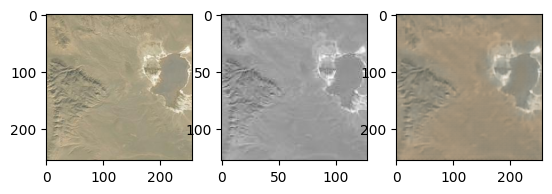

i: 607
LEFT TO RIGHT: ORIGINAL, DOWNSIZED GRAYSCALE INPUT, COLORIZED OUTPUT
tensor(0.0007, grad_fn=<MseLossBackward0>)


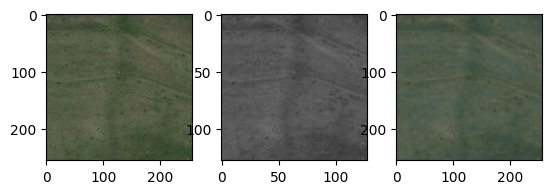

i: 760
LEFT TO RIGHT: ORIGINAL, DOWNSIZED GRAYSCALE INPUT, COLORIZED OUTPUT
tensor(0.0041, grad_fn=<MseLossBackward0>)


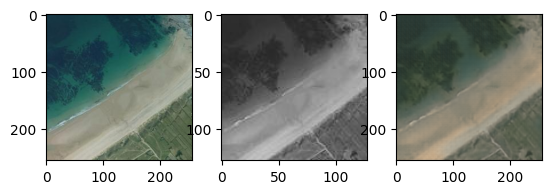

In [16]:
autoencoder.eval()
for i in np.random.randint(n_test,size=3):
  image_bw = gray_test[i]
  image_c = color_test[i]

  # Colorize the image
  t = gray_test_tensors[i].unsqueeze(0).to(device)
  colorized_image = autoencoder(t)
  colorized_image_format = np.moveaxis(colorized_image.squeeze().cpu().detach().numpy(), [1,2], [0,1])

  print("i:", i)
  print("LEFT TO RIGHT: ORIGINAL, DOWNSIZED GRAYSCALE INPUT, COLORIZED OUTPUT")
  print(nn.MSELoss()(colorized_image.cpu(), color_test_tensors[i]))

  plt.subplot(1,3,1)
  plt.imshow(image_c)
  plt.subplot(1,3,2)
  plt.imshow(image_bw)
  plt.subplot(1,3,3)
  plt.imshow(colorized_image_format)
  plt.show()

# Visualize model

Using [pytorchviz](https://github.com/szagoruyko/pytorchviz)!

In [ ]:
!pip install torchviz

In [ ]:
from torchviz import make_dot
make_dot(colorized_image.mean(), params=dict(autoencoder.named_parameters()))

Save current model

In [ ]:
torch.save(autoencoder.encoder,'/content/CPSC-440-Project/models/128_dim_encoder_weights')

# 4. Push changes

Look for any changes in the project directory, excluding this notebook, and push them.


In [ ]:
cd CPSC-440-Project

/content/CPSC-440-Project


In [ ]:
!git add .

In [ ]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes to be committed:
  (use "git restore --staged <file>..." to unstage)
	new file:   models/128_dim_encoder_weights



In [ ]:
!git commit -m "Preliminary 128x128 size model weights"

[main 9528cc674] Preliminary 128x128 size model weights
 1 file changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 models/128_dim_encoder_weights


In [ ]:
!git push

Enumerating objects: 6, done.
Counting objects: 100% (6/6), done.
Delta compression using up to 12 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 630.82 KiB | 14.34 MiB/s, done.
Total 4 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/StuartLiv/CPSC-440-Project
   fd60ca23f..9528cc674  main -> main


In [ ]:
# autoencoder.decoder = torch.load('/content/CPSC-440-Project/models/decoder_weights')

# autoencoder.encoder = torch.load('/content/CPSC-440-Project/models/full_size_encoder_weights') # need some weights saved here!

# 4. Save notebook

Commiting this notebook requires a special maneuver:

> File > Save a copy in github > enter original `path` + new commit msg

That's it!